In [ ]:
import os #inorder to support the os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets , transforms
import matplotlib.pyplot as plt
from sklearn.utils import shuffle #training and testing
import pandas as pd #for reading and creating dataframes from the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#define class names
class_names = ["Apple___Apple_scab","Apple___Black_rot,Apple___Cedar_apple_rust","Apple___Healthy,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot","Corn_(maize)___Northern_Leaf_Blight,Grape___Black_rot"]

class_names_label = {class_name:i for i,class_name in enumerate(class_names)}
nb_classes = len(class_names)

IMAGE_SIZE = (150 , 150)#we are mentioning the size of the data for the project
BATCH_SIZE = 32

In [ ]:
#define transformations (data preprocessing)
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406] , [0.229 , 0.224 , 0.225])
])

In [ ]:
#load datasets
train_dataset = datasets.ImageFolder(root=r'/content/drive/MyDrive/plant disease using CNN/test',transform=transform)
test_dataset = datasets.ImageFolder(root=r'/content/drive/MyDrive/plant disease using CNN/test',transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle=True)#for training purpose we shuffle the data

test_loader = DataLoader(test_dataset , batch_size=BATCH_SIZE , shuffle=False)#no need for shuffling for testing as ]1

In [ ]:
#check the dataset size
n_train = len(train_dataset)
n_test = len(test_dataset)


print(f"number of training examples : {n_train}")
print(f"number of testing examples : {n_test}")
print(f"each image is of the size : {IMAGE_SIZE}")

number of training examples : 106
number of testing examples : 106
each image is of the size : (150, 150)


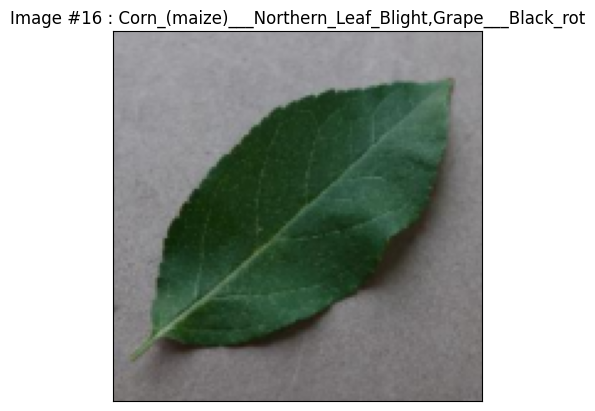

In [ ]:
#Visualizing the data
def display_random_image(loader , class_names):
  """
  Display a random image from the dataset and its corresponding label.
  """
  #get a batch of data
  dataiter = iter(loader)
  images , labels = next(dataiter)

  index = np.random.randint(len(labels))#get a random index
  image = images[index].numpy().transpose(1,2,0)#transpose for correct display

  #unnormalize the image for correct visualization(reverse of normalization)
  image = image * np.array([0.229 , 0.224 , 0.225]) + np.array([0.485 , 0.456 , 0.406])
  image = np.clip(image , 0 , 1)

  plt.figure()
  plt.imshow(image)
  plt.xticks([])#nothing is mentioned as this is an image
  plt.yticks([])
  plt.grid(False)
  plt.title(f"Image #{index} : {class_names[labels[index]]}")
  plt.show()

#calling the function
display_random_image(train_loader , class_names)



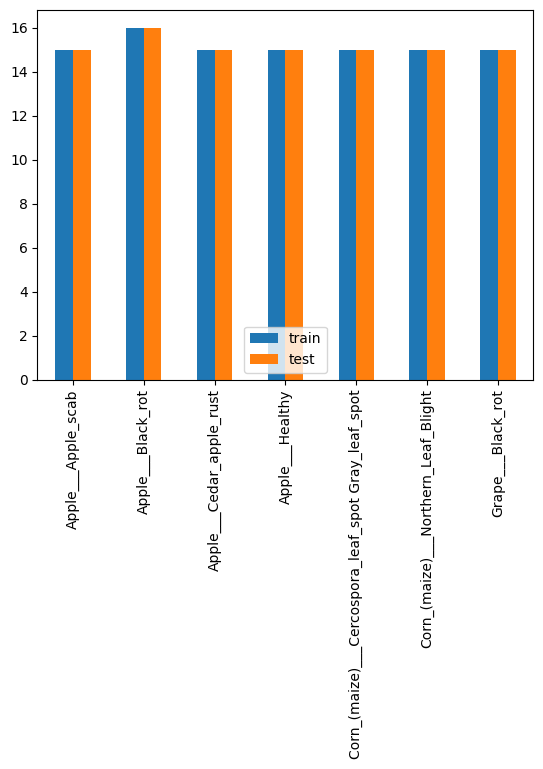

In [ ]:
# Plotting dataset distribution
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]
# Get unique labels and their counts
unique_labels, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
# Ensure class_names align with unique labels from dataset
class_names = [train_dataset.classes[label] for label in unique_labels]
# Create DataFrame and plot
pd.DataFrame({'train': train_counts, 'test': test_counts}, index=class_names).plot.bar()
plt.show()

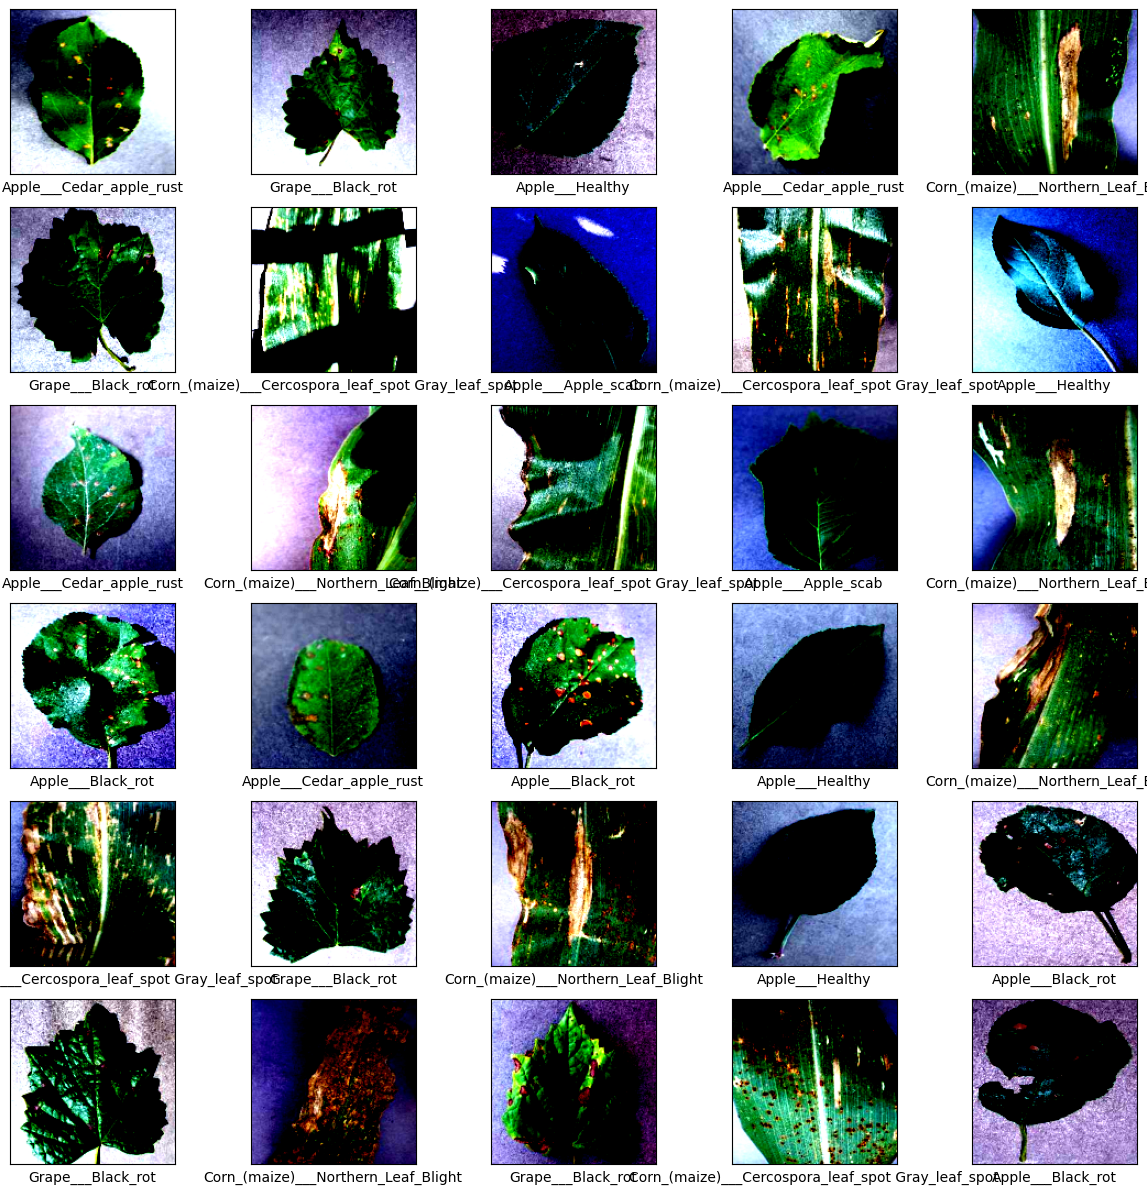

In [ ]:
def display_examples(class_names,loader):
  num_examples = 30
  dataiter = iter(loader)
  images , labels = next(dataiter)

  plt.figure(figsize=(15,15))
  for i in range(min(num_examples , len(images))):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])

    #convert tensor to numpy and clip the values to [0,1] range for imshow
    image = images[i].numpy().transpose(1,2,0)
    image = np.clip(image , 0 , 1)

    plt.imshow(image)
    plt.xlabel(class_names[labels[i].item()])
  plt.show()

_display_examples(class_names , train_loader)

In [ ]:
import torch #for nn
import torch.nn as nn
import torch.optim as optim#weight value and bias value optimizer
import torchvision
import torchvision.transforms as transforms


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)#3 inputs
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)#for more precision we need to increase the filter size to 64
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2 , padding=0)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

        #calculate the size of the flattened feature vector
        self.flattened_size = self._get_flattened_size()

        #define fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, len(class_names))#output size is the number of


    def _get_flattened_size(self):
        #use a dummy tensor to calculate the sizr after conv and pool layers
        with torch.no_grad():
          x=torch.zeros(1,3,150,150)
          x = self.conv1(x)
          x = self.relu(x)
          x = self.pool(x)
          x = self.conv2(x)
          x = self.relu(x)
          x = self.pool(x)
          return x.view(-1).size(0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, self.flattened_size)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 11

#data transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], (0.299, 0.224, 0.225))
])

trainset = torchvision.datasets.ImageFolder(root=r'/content/drive/MyDrive/plant disease using CNN/test', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.ImageFolder(root=r'/content/drive/MyDrive/plant disease using CNN/test',transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Use testloader for testing

#define class names
class_names = trainset.classes

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print('Finished Training')

# Testing the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader: # Iterate through testloader
        outputs = model(images) # Pass images to the model
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Finished Training
Accuracy on the test set: 92.45283018867924%
